In [ ]:
%pip install tensorflow opencv-python matplotlib

In [ ]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM error by setting up GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import cv2
import imghdr

/tmp/ipykernel_11837/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir='data'
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [16]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)
            

In [ ]:
tf.data.Dataset


In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [18]:
data =tf.keras.utils.image_dataset_from_directory('data')

Found 146 files belonging to 2 classes.


In [19]:
data_iterator = data.as_numpy_iterator()

In [29]:
batch =data_iterator.next()

(array([[[[177.09215  , 148.09215  , 134.09215  ],
          [178.       , 149.       , 135.       ],
          [179.07402  , 150.07402  , 134.07402  ],
          ...,
          [234.       , 219.       , 200.       ],
          [234.       , 219.       , 200.       ],
          [234.       , 219.       , 200.       ]],
 
         [[177.7802   , 148.7802   , 134.7802   ],
          [178.24925  , 149.24925  , 135.24925  ],
          [179.74083  , 150.74083  , 134.74083  ],
          ...,
          [234.       , 219.       , 200.       ],
          [234.       , 219.       , 200.       ],
          [234.       , 219.       , 200.       ]],
 
         [[178.9668   , 149.9668   , 135.9668   ],
          [179.39648  , 150.39648  , 136.39648  ],
          [180.3701   , 151.3701   , 135.3701   ],
          ...,
          [234.       , 219.       , 200.       ],
          [234.       , 219.       , 200.       ],
          [234.       , 219.       , 200.       ]],
 
         ...,
 
         [[1

In [22]:
len(batch)

2

In [23]:
# Images representation as numpy array
batch[0].shape

(32, 256, 256, 3)

In [30]:
# Batch 0 is happy baby
# Batch 1 is sad baby
batch[1]

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0], dtype=int32)

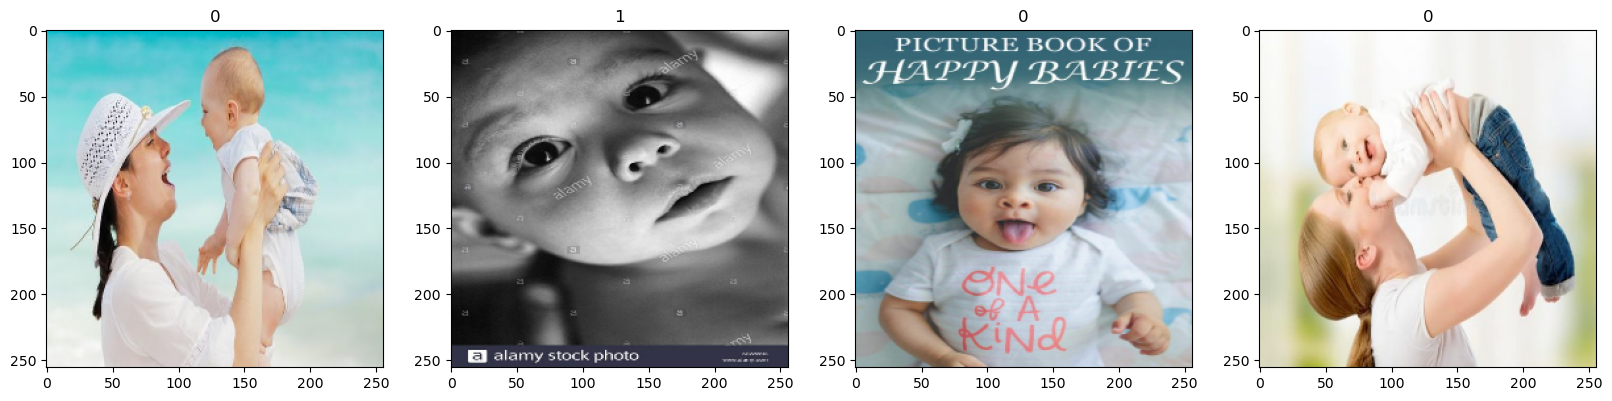

In [31]:
fig,ax =plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 2. Pre-Process Data

In [32]:
data =data.map(lambda x,y:(x/255,y))

In [37]:
data.as_numpy_iterator().next()[0].max()

1.0

In [55]:
len(data)

5

In [51]:
train_size=int(len(data)*.7)
val_size=int(len(data)*.2)+1
test_size=int(len(data)*.1)+1

In [64]:
train =data.take(train_size)
test =data.skip(train_size).take(test_size)
val =test.skip(train_size+test_size).take(val_size)

## 3. Model Processing

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

In [66]:
model=Sequential()

In [67]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [68]:
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

/home/alexander/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [69]:
model.compile(optimizer='adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,843,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,853,169 (7.07 MB)

 Trainable params: 1,853,169 (7.07 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
log_dir='logs'

In [72]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

In [73]:
history =model.fit(train,validation_data=val,epochs=20,callbacks=[tensorboard_callback])

Epoch 1/20


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4861 - loss: 0.8644

2024-10-12 13:01:11.430818: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4792 - loss: 0.8773
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5486 - loss: 0.7267

2024-10-12 13:01:17.292605: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5495 - loss: 0.7205
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7031 - loss: 0.6396
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6597 - loss: 0.5940

2024-10-12 13:01:28.730376: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6693 - loss: 0.5892
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5938 - loss: 0.5998
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7057 - loss: 0.5280
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7539 - loss: 0.4894
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8403 - loss: 0.4275

2024-10-12 13:02:01.442810: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8464 - loss: 0.4239
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8477 - loss: 0.3636
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7891 - loss: 0.4855
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.6406 - loss: 0.5043
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.8776 - loss: 0.3337
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9102 - loss: 0.3128
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9023 - loss: 0.2684
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9076 - loss: 0.2843
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9306 - loss: 0.2190

2024-10-12 13:03:07.312318: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9271 - loss: 0.2255
Epoch 17/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9505 - loss: 0.1593
Epoch 18/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8880 - loss: 0.2426
Epoch 19/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8867 - loss: 0.2299
Epoch 20/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9635 - loss: 0.1660


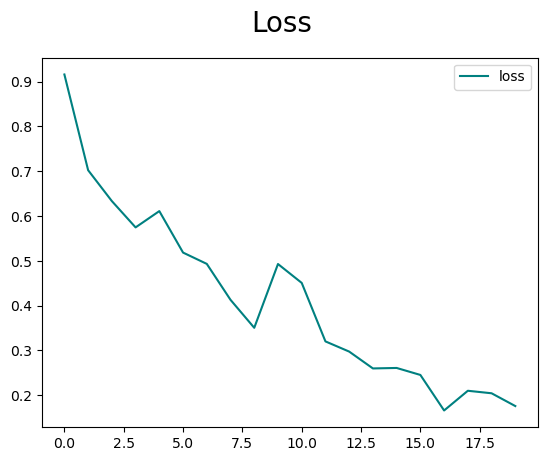

In [77]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

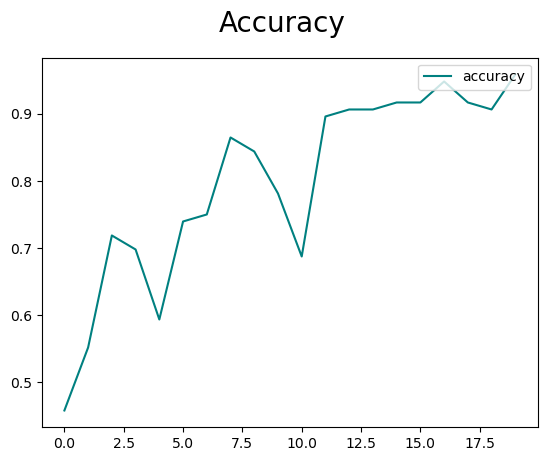

In [78]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
if 'valaccuracy' in history.history:
    plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper right')
plt.show()

In [79]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [80]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [81]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


In [82]:
print(pre.result(), re.result(), acc.result())


tf.Tensor(0.8235294, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.90625, shape=(), dtype=float32)


## 4. Test

In [83]:
import cv2


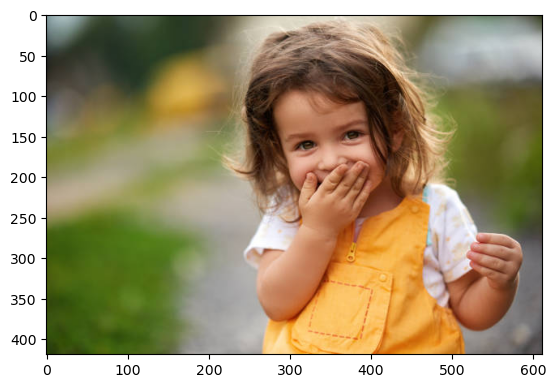

In [131]:
img = cv2.imread('jubi.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

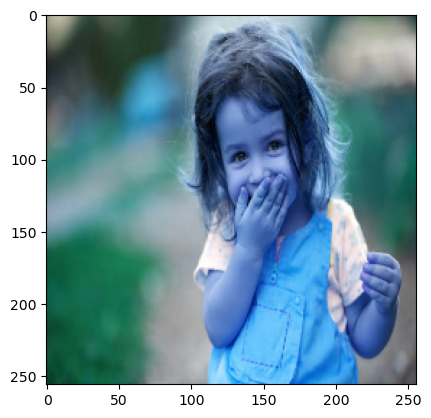

In [132]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [133]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [134]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [135]:
yhat

array([[0.43355444]], dtype=float32)

In [136]:
if yhat > 0.5: 
    print(f'Predicted class is a Sad Baby')
else:
    print(f'Predicted class is a Happy Baby')

Predicted class is a Happy Baby


In [137]:
from tensorflow.keras.models import load_model


In [143]:
model.save(os.path.join('models','imageclassifier.h5'))


In [145]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))


In [146]:
new_model.predict(np.expand_dims(resize/255, 0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


array([[0.43355444]], dtype=float32)